In [176]:
%load_ext autoreload
%autoreload 2

import torch 
import pyro
import inspect

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
from PFNExperiments.LinearRegression.GenerativeModels.GenerateData import GenerateData, check_data, check_and_plot_data
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_Examples import make_lm_program_plain, make_lm_program_gamma_gamma, make_lm_program_gamma_gamma_augmented
from PFNExperiments.LinearRegression.GenerativeModels.LM_abstract import return_only_y, print_code

        def multivariate_lm_return_dict(x: torch.tensor, y: torch.tensor = None) -> dict:
                sigma_squared = (pyro.sample("sigma_squared", pyro.distributions.Gamma(a0, b0)) + 0.1)/10000
                
                tau = (pyro.sample("tau", pyro.distributions.Gamma(a1,b1)) + 0.1)/10

                beta_mean = torch.zeros(x.shape[1])
                beta_cov = (1/tau) * torch.eye(x.shape[1])

                beta = pyro.sample("beta", pyro.distributions.MultivariateNormal(beta_mean, beta_cov))

                mean = torch.matmul(x, beta)

                with pyro.plate("data", len(x)):
                        y = pyro.sample("obs", pyro.distributions.Normal(mean, sigma_squared), obs=y)

                return {
                        "x": x,
                        "y": y,
                        "sigma_squared": sigma_squared,
                        "tau": tau,
                        "beta": beta
                }



100%|██████████| 1000/1000 [00:01<00:00, 647.27it/s]


Discarded 0 samples
{'X': {'mean': tensor(0.5000), 'variance': tensor(0.0834), 'min': tensor(1.2517e-06), 'max': tensor(1.0000)}, 'y': {'mean': tensor(-0.0198), 'variance': tensor(4.9086), 'min': tensor(-10.6805), 'max': tensor(16.0504)}, 'beta': {'mean': tensor([-0.0558,  0.0157,  0.0093]), 'variance': tensor([5.0303, 4.8770, 5.2195]), 'min': tensor([-7.8490, -8.0011, -8.7611]), 'max': tensor([12.0784,  9.9393, 11.0783])}}
Statistics for sigma_squared:
Mean: 0.00026647280901670456
Variance: 1.2801398163730937e-08
Min: 5.852946196682751e-05
Max: 0.0007402894552797079


Statistics for tau:
Mean: 0.2537151575088501
Variance: 0.011893571354448795
Min: 0.0456341877579689
Max: 0.6996963024139404




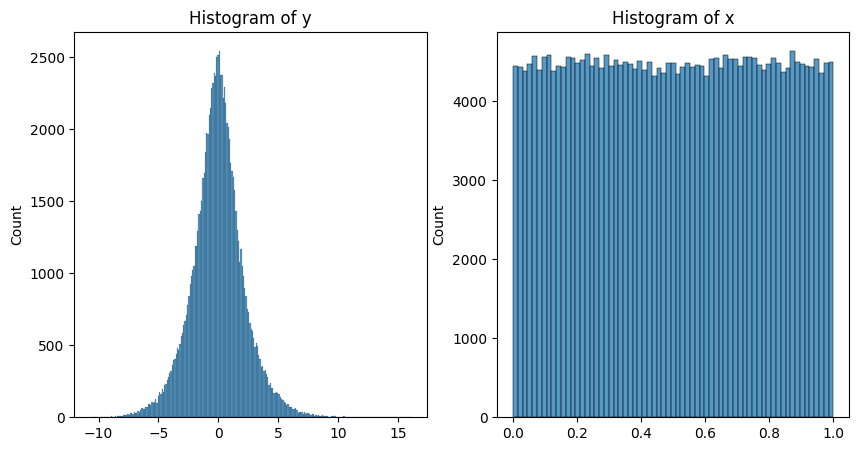

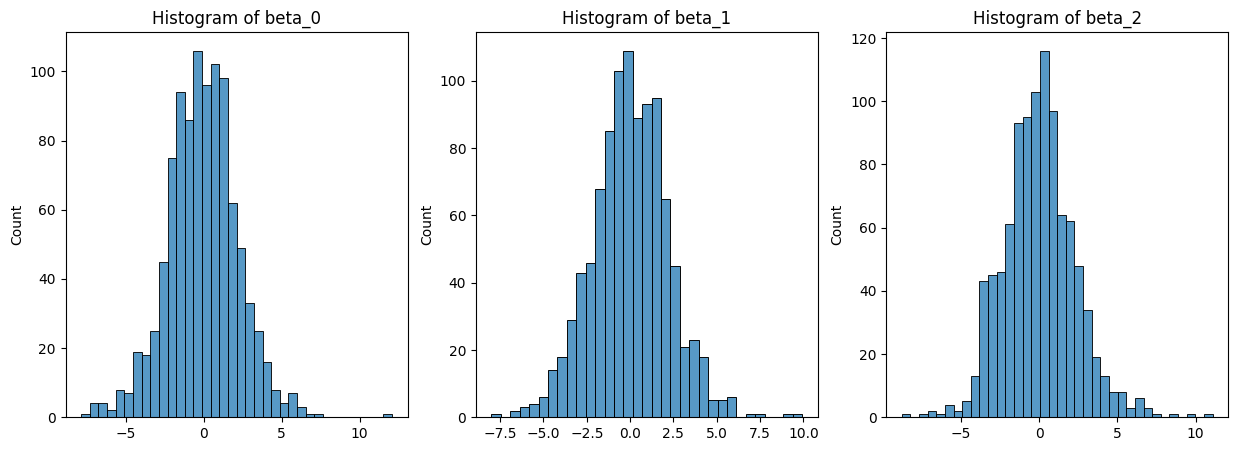

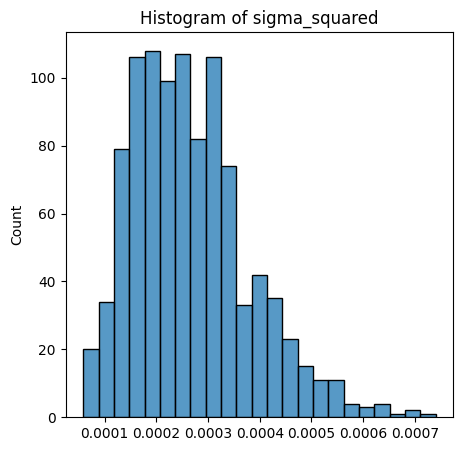

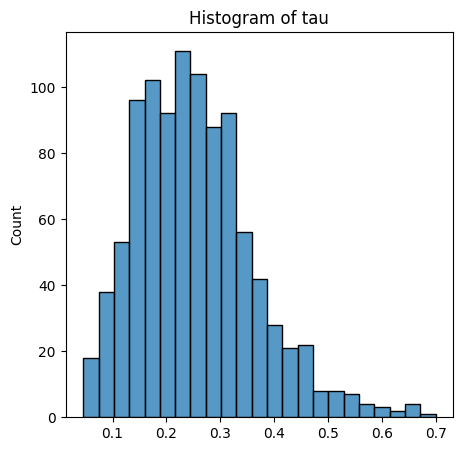

In [178]:
x_test = torch.rand(10, 5)
pprogram1 = make_lm_program_gamma_gamma_augmented()
pprogram1_y = return_only_y(pprogram1)
pprogram1
print_code(pprogram1)
generator = GenerateData(pprogram1)
generator.render_model()
_ = generator.check_model()


In [179]:
loader = generator.make_dataloaders_dynamic(
    n_batch=1000,
    
)

In [180]:
train_loader, val_loader, test_loader = loader

In [248]:
from PFNExperiments.LinearRegression.Models.Transformer import Transformer

In [249]:
batch = next(iter(train_loader))
x = batch['x']
y = batch['y']
beta = batch['beta']

In [250]:
print(x.shape)

torch.Size([256, 100, 5])


In [251]:
X_y = torch.cat([x, y.unsqueeze(-1)], dim = -1)

In [252]:
X_y = torch.cat([x, y.unsqueeze(-1)], dim = -1)

In [253]:
batch = next(iter(train_loader))
x = batch['x']
y = batch['y']
beta = batch['beta']
print(x.shape)
X_y = torch.cat([x, y.unsqueeze(-1)], dim = -1)

torch.Size([256, 100, 5])


In [254]:
def batch_to_model(batch:dict) -> torch.tensor:
    x = batch['x']
    y = batch['y']
    X_y = torch.cat([x, y.unsqueeze(-1)], dim = -1)
    return X_y

In [271]:
model = Transformer(
    n_features=6,
    seq_len=100,
    d_model=126,
    n_heads=2,
    dim_feedforward=126,
    n_layers=4,
    n_output_units_per_head=[5, 5*5, 5]
)

In [256]:
out = model(X_y)

In [270]:
 mu, cov_factor, cov_diag = out

In [262]:
from PFNExperiments.Training.Trainer import Trainer, batch_to_model_lm, visualize_results
from PFNExperiments.Training.Losses import MSELoss_unsqueezed

from PFNExperiments.Training.EvalMetrics import mean_squared_error_torch_avg, mae_torch_avg, r2_score_torch_avg

In [263]:
def get_transformer_schedule_with_warmup(optimizer, d_model, warmup_steps):
    """
    Returns a scheduler with a learning rate that increases linearly from 0 to 1 over `warmup_steps` training steps,
    and decreases proportionally to the inverse square root of the step number after `warmup_steps`.
    """
    def lr_lambda(step_num):
        # Scale the learning rate according to the transformer schedule
        step_num = max(1, step_num)
        return d_model ** (-0.5) * min(step_num ** (-0.5), step_num * warmup_steps ** (-1.5))

    return LambdaLR(optimizer, lr_lambda)

# Example usage:
# Assuming `model` is your transformer model and `optimizer` is initialized with your model parameters
d_model = 1024
warmup_steps = 4000


optimizer = torch.optim.Adam(model.parameters(), lr=0.0, betas=(0.9, 0.98), eps=1e-9)
scheduler = get_transformer_schedule_with_warmup(optimizer, d_model, warmup_steps)

In [264]:
from PFNExperiments.LinearRegression.Models.ModelPosterior import ModelPosteriorFullGaussian

In [292]:
nll_loss = ModelPosteriorFullGaussian(cov_reg_factor = 1e-6).negative_log_likelihood
nll_loss_avg = ModelPosteriorFullGaussian(cov_reg_factor = 1e-6).negative_log_likelihood_avg

In [293]:
lr = 1e-3
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

In [295]:
additional_evals = {
    "loss": mean_squared_error_torch_avg
    "mae": mean_squared_error_torch_avg,
    "r2": r2_score_torch_avg
}
trainer = Trainer(
    model = model,
    optimizer=opt,
    scheduler = None,
    loss_function=MSELoss_unsqueezed,
    trainset = train_loader,
    valset=val_loader,
    evaluation_functions= additional_evals,
    n_epochs = 1000,
    early_stopping_patience = 20  
)

In [296]:
trainer.validate()

{'loss': tensor(249.3815)}

In [297]:
r = trainer.train()

100%|██████████| 3/3 [00:07<00:00,  2.40s/it]


Epoch 0:
Training: {'loss': tensor(23.1519)}
Validation: {'loss': tensor(56.2228)}
Time: 7.706122636795044


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


Epoch 1:
Training: {'loss': tensor(20.2107)}
Validation: {'loss': tensor(59.7524)}
Time: 6.158250570297241


----------------------------------------------------------------------------------------------------


100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Epoch 2:
Training: {'loss': tensor(16.4508)}
Validation: {'loss': tensor(51.2080)}
Time: 5.65361475944519


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


Epoch 3:
Training: {'loss': tensor(17.5200)}
Validation: {'loss': tensor(20.6784)}
Time: 5.240826368331909


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch 4:
Training: {'loss': tensor(14.1010)}
Validation: {'loss': tensor(11.9817)}
Time: 5.665975570678711


----------------------------------------------------------------------------------------------------
Saving model


 67%|██████▋   | 2/3 [00:03<00:01,  1.97s/it]


KeyboardInterrupt: 

In [ ]:
r[0]

[{'mae': tensor(1.7215, dtype=torch.float64),
  'r2': tensor(-9.9445, dtype=torch.float64),
  'loss': tensor(4.8613)},
 {'mae': tensor(1.5725, dtype=torch.float64),
  'r2': tensor(-4.2949, dtype=torch.float64),
  'loss': tensor(4.0592)},
 {'mae': tensor(1.5722, dtype=torch.float64),
  'r2': tensor(-3.8882, dtype=torch.float64),
  'loss': tensor(4.0486)},
 {'mae': tensor(1.5185, dtype=torch.float64),
  'r2': tensor(-2.8312, dtype=torch.float64),
  'loss': tensor(3.8880)},
 {'mae': tensor(1.5690, dtype=torch.float64),
  'r2': tensor(-2.7139, dtype=torch.float64),
  'loss': tensor(4.1099)},
 {'mae': tensor(1.5051, dtype=torch.float64),
  'r2': tensor(-2.3316, dtype=torch.float64),
  'loss': tensor(3.7498)},
 {'mae': tensor(1.5308, dtype=torch.float64),
  'r2': tensor(-2.7933, dtype=torch.float64),
  'loss': tensor(3.9007)},
 {'mae': tensor(1.5450, dtype=torch.float64),
  'r2': tensor(-2.8078, dtype=torch.float64),
  'loss': tensor(3.9161)},
 {'mae': tensor(1.5385, dtype=torch.float64),
  

C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\Training\Trainer.py:236: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


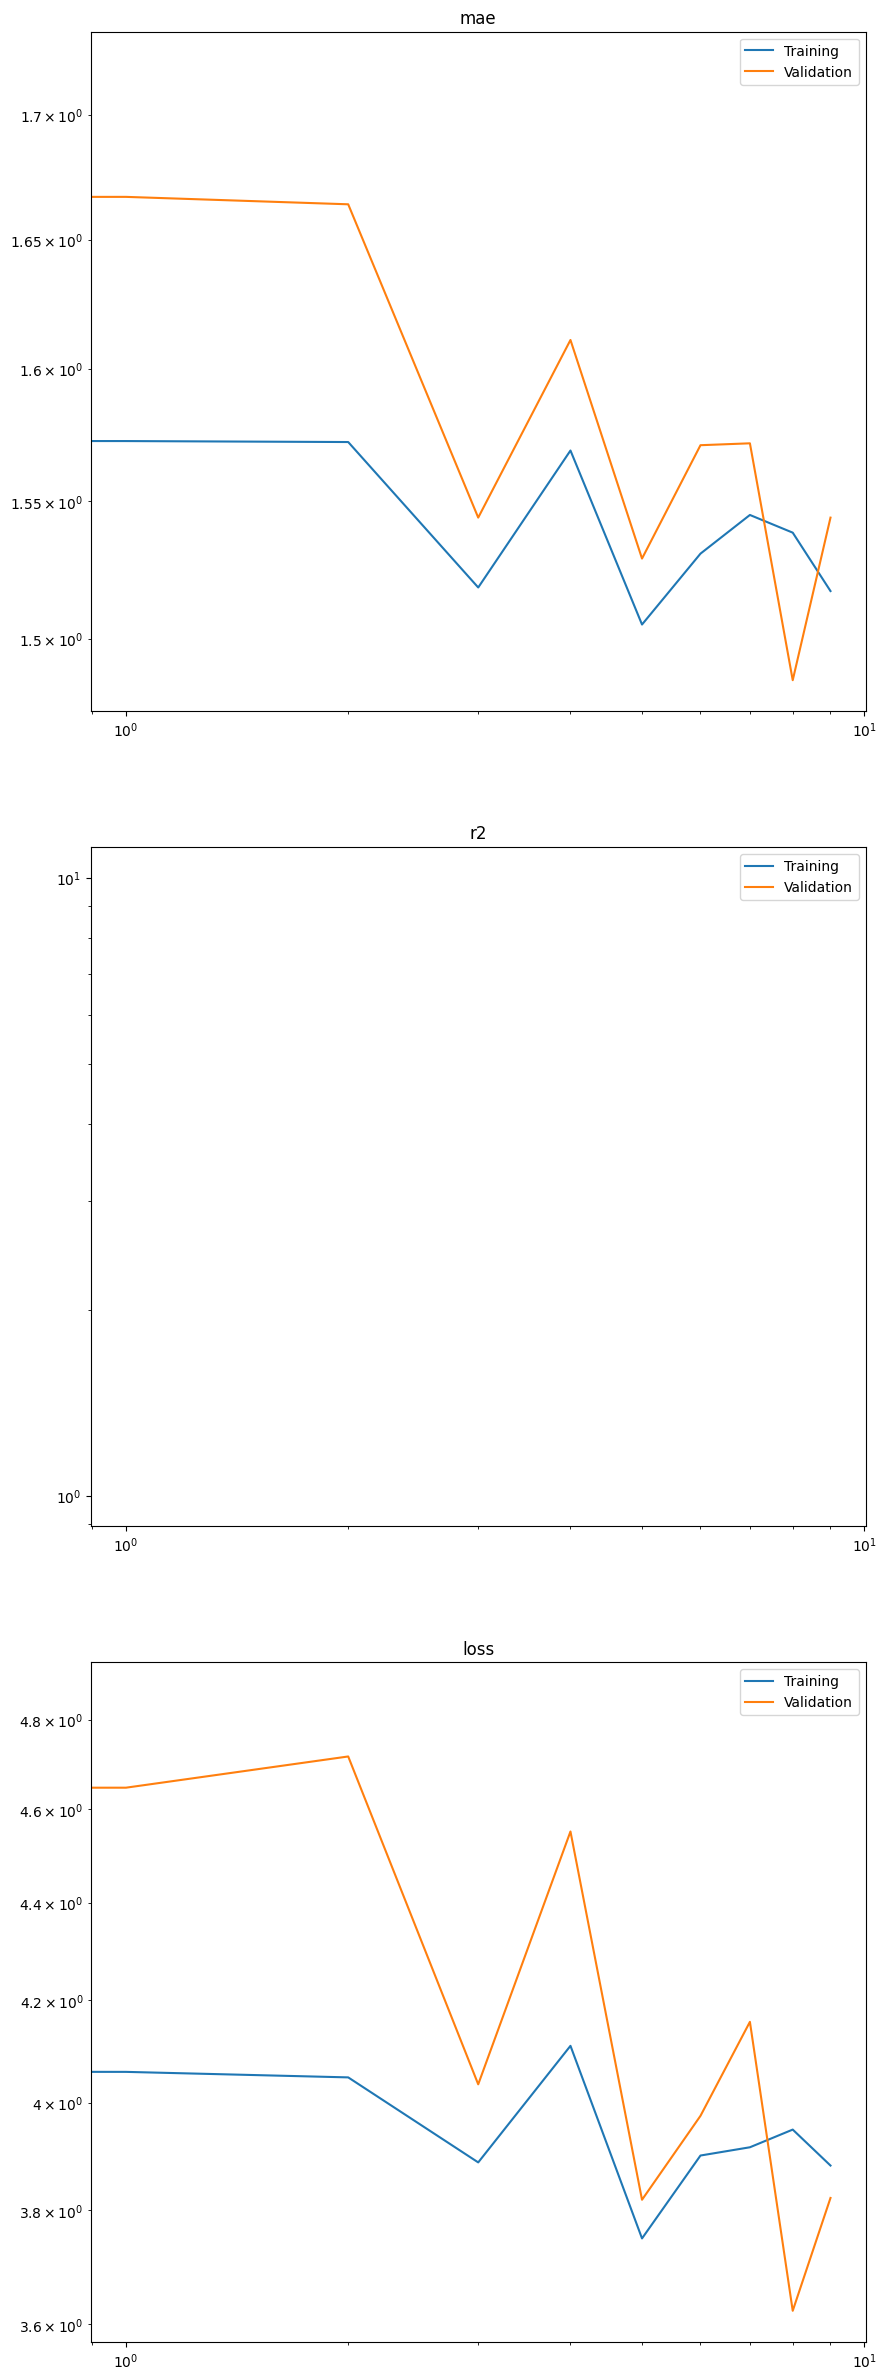

In [ ]:
visualize_results(r)

In [ ]:
r

([{'mae': tensor(1.7215, dtype=torch.float64),
   'r2': tensor(-9.9445, dtype=torch.float64),
   'loss': tensor(4.8613)},
  {'mae': tensor(1.5725, dtype=torch.float64),
   'r2': tensor(-4.2949, dtype=torch.float64),
   'loss': tensor(4.0592)},
  {'mae': tensor(1.5722, dtype=torch.float64),
   'r2': tensor(-3.8882, dtype=torch.float64),
   'loss': tensor(4.0486)},
  {'mae': tensor(1.5185, dtype=torch.float64),
   'r2': tensor(-2.8312, dtype=torch.float64),
   'loss': tensor(3.8880)},
  {'mae': tensor(1.5690, dtype=torch.float64),
   'r2': tensor(-2.7139, dtype=torch.float64),
   'loss': tensor(4.1099)},
  {'mae': tensor(1.5051, dtype=torch.float64),
   'r2': tensor(-2.3316, dtype=torch.float64),
   'loss': tensor(3.7498)},
  {'mae': tensor(1.5308, dtype=torch.float64),
   'r2': tensor(-2.7933, dtype=torch.float64),
   'loss': tensor(3.9007)},
  {'mae': tensor(1.5450, dtype=torch.float64),
   'r2': tensor(-2.8078, dtype=torch.float64),
   'loss': tensor(3.9161)},
  {'mae': tensor(1.5385,